## Chapter 5
# Detection Using Cross Correlation With Whistler Kernel

In [1]:
import os, sys
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from tqdm import tqdm
import h5py
# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))
linewidth = 2
font_title = 32
font_legend = 20
font_label = 24
font_ticks = 18
font = [font_title, font_legend, font_label, font_ticks, linewidth] # [None]*5

## **5.2 Kernels**

### **Kernel Extracted From Data**

**Generate Whistler Cuts**

Generate cuts of whistler from the training set, using the AWD output

In [2]:
from database import Database
from cfar_detector import CFARDetector

dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
site = 'sanae'
database = Database(dataset_loc, database_loc, site)
sample = CFARDetector(dataset_loc, site, np.random.choice(database.get_train(),1)[0])
transforms = ['zscore']
transforms_params = [['None']]
cut_params=[2.5,0.3,7,2,2]
database.create_cuts_db_mp(transforms=transforms, transforms_params=transforms_params,
                              cut_params=cut_params, verbose=True, noise=False, train=True, test=False)
X,Y = database.load_cuts_db_mp(transforms=transforms, transforms_params=transforms_params,
                              cut_params=cut_params, verbose=True, noise=False, test=False)
X_mean = X.mean(axis=0)#database.whistler_mean(transforms=transforms, transforms_params=transforms_params, cut_params=cut_params)

100%|██████████| 373/373 [00:09<00:00, 37.86it/s]


/srv/home/knnoth001/wdml/data/databases/awdEvents1/sanae/sanae_h5/['zscore']_[['None']]_[2.5, 0.3, 7, 2, 2]_False/train
samples:  1719


100%|██████████| 1719/1719 [00:01<00:00, 1308.54it/s]


**Show examples of whistler cuts**

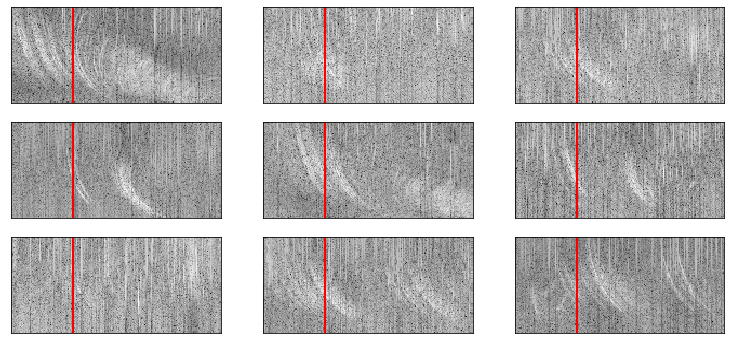

In [3]:
x_size, y_size, ix = 3,3,0
fig, axes = plt.subplots(x_size, y_size, figsize=(x_size*(X_mean.shape[1]/X_mean.shape[0])*2,y_size*2))
for x in range(x_size):
    for y in range(y_size):
        axes[x,y].pcolormesh(X[ix], cmap='gray')
        axes[x,y].axvline(int((cut_params[0]*cut_params[1])/sample.get_time_res()), color='r',linewidth=font[-1])
        axes[x,y].set_xticks([])
        axes[x,y].set_yticks([])
        ix += 1
# fig.suptitle('Whislter cuts')
plt.show()

**Mean of the cut as a kernel**

Analyse the mean to define the appropriate cut

(91, 194)


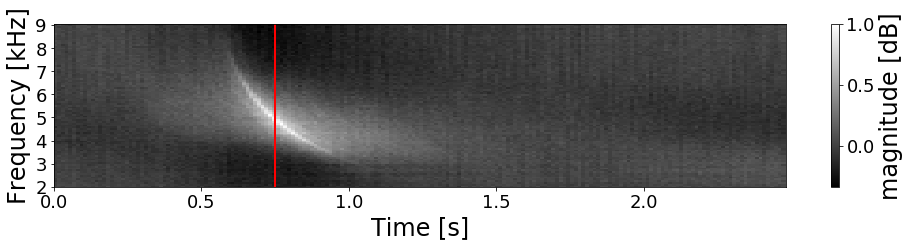

In [6]:
X_mean = X.mean(axis=0)
scale = lambda x: (x-x.min())/(x.max()-x.min())
print(X_mean.shape)
# X_mean = scale(X_mean)
x = np.linspace(0,X_mean.shape[1],X_mean.shape[1]+1)*sample.get_time_res()
y = np.linspace(0,X_mean.shape[0],X_mean.shape[0]+1)*sample.get_freq_res()+2
n=3
fig = plt.figure(figsize=(n*(X_mean.shape[1]/X_mean.shape[0])+10,n)); 
img = plt.pcolormesh(x,y,X_mean, cmap='gray')
c = fig.colorbar(mappable=img)
c.set_label('magnitude [dB]', fontsize=font[2])
c.ax.tick_params(labelsize=font[3])
plt.axvline((cut_params[0]*cut_params[1]), color='r', linewidth=font[-1])
plt.xticks(fontsize=font[3])
plt.yticks(fontsize=font[3])
plt.xlabel('Time [s]',fontsize=font[2])
plt.ylabel('Frequency [kHz]',fontsize=font[2])
# plt.title('Whistler extracted from data')
plt.show()

### **Bernard Approximation**

**Correlation between Mean and Simulated whistlers**

20.0 0.22 21.93 0.59
35.0 0.37 38.78 0.52
50.0 0.54 33.72 0.45
65.0 0.69 31.73 0.37
80.0 0.84 31.83 0.2


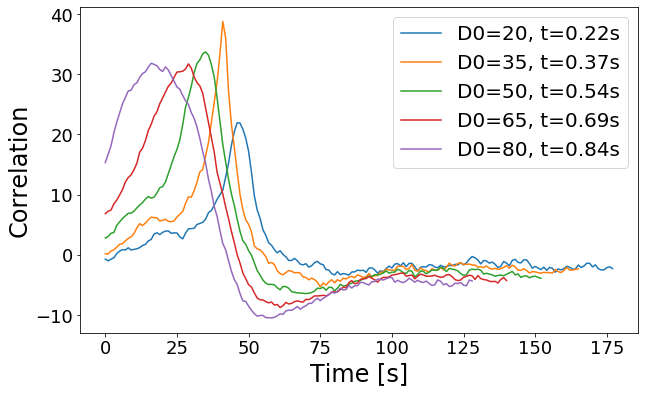

In [21]:
import os, sys
import numpy as np
from scipy import signal
from PIL import Image

sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))
from database import Database
from cfar_detector import CFARDetector
from dataset_simulation import DatasetSimulation

dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
dataset_sim_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'simulations', 'simple' ,'whistler')
site = 'sanae'

database = Database(dataset_loc, database_loc, site)
sample = CFARDetector(dataset_loc, site, np.random.choice(database.get_train(),1)[0])
dataset_sim = DatasetSimulation(dataset_sim_loc, sample.get_time_res(), sample.get_freq_res())
dataset_sim.set_frequency_range(np.linspace(2e3, 8e3, 1000))

y_min, y_max = 2,8
plt.figure(figsize=(10,6))
legend = []
# plt.plot(x_axis, corr)
An, D0, magnitude = 0.35, 20, 1
for D0 in np.linspace(20,80,5):
    data = dataset_sim.whistler_sim(An=An, D0=D0, magnitude=magnitude)
    duration = round(data.shape[1]*sample.get_time_res(),2)
    legend.append('D0=%d, t=%.2fs'%(D0,duration))
    _X_mean = X_mean[int(y_min/sample.get_freq_res()):int(y_max/sample.get_freq_res()),:]
    corr = signal.correlate2d(_X_mean, data, mode='valid')[0]
    print(D0, duration, round(corr[corr.argmax()],2), round(corr.argmax()*sample.get_time_res(),2))
    plt.plot(corr)
plt.xticks(fontsize=font[3])
plt.yticks(fontsize=font[3])
plt.legend(legend, fontsize=font[1])
plt.xlabel('Time [s]', fontsize=font[2])
plt.ylabel('Correlation', fontsize=font[2])
# plt.title('Whistler correlation')
plt.show()


**Example of Simulated Kernel to be used**

0.52
0.75
1.05


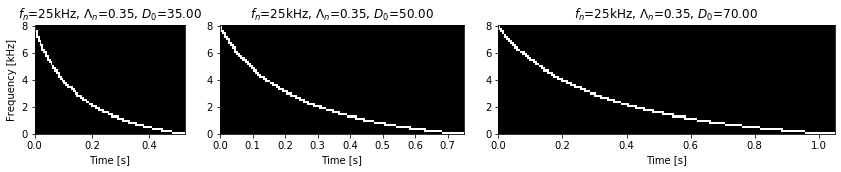

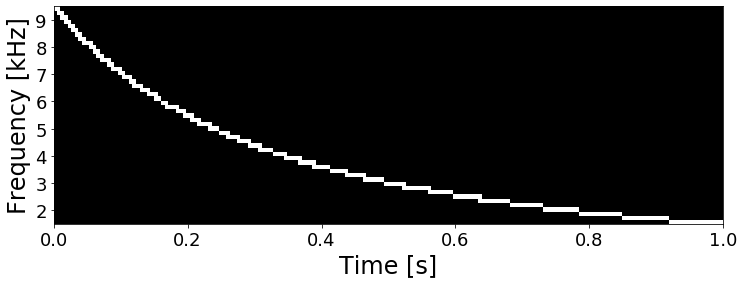

In [11]:
An, D0, magnitude = 0.45, 40, 1
fig = plt.figure(figsize=(2*8,2))
grid = plt.GridSpec(1, 10, wspace=0.6, hspace=0)
axes = [fig.add_subplot(grid[0, 0:2]),fig.add_subplot(grid[0, 2:5]),fig.add_subplot(grid[0,5:-1])]
ix = 0
for D0 in [35,50,70]:
    data = dataset_sim.whistler_sim(An=An, D0=D0, magnitude=magnitude)
    x = np.linspace(0,data.shape[1],data.shape[1]+1)*sample.get_time_res()
    print(round(x[-1],2))
    y = np.linspace(0,data.shape[0],data.shape[0]+1)*sample.get_freq_res()
    img = axes[ix].pcolormesh(x,y,data, cmap='gray')
#     fig.colorbar(mappable=img, label='magnitude [dB]')
    axes[ix].set_xlabel('Time [s]')
    axes[0].set_ylabel('Frequency [kHz]')
    axes[ix].set_title('$f_n$=%dkHz, $\Lambda_n$=%.2f, $D_0$=%.2f'%(25,0.35,D0))
    ix += 1
plt.show()
fig = plt.figure(figsize=(4*3,4))
An, D0, magnitude = 0.45, 80, 3
data = dataset_sim.whistler_sim(An=An, D0=D0, magnitude=magnitude)
x = np.linspace(0, x_max-x_min, data.shape[1])
y = np.linspace(y_min, y_max, data.shape[0])
img = plt.pcolormesh(x,y,data, cmap='gray')
plt.xticks(fontsize=font[3])
plt.yticks(fontsize=font[3])
plt.xlabel('Time [s]',fontsize=font[2])
plt.ylabel('Frequency [kHz]',fontsize=font[2])
# plt.title('$f_n$=%dkHz, $\Lambda_n$=%.2f, $D_0$=%.2f'%(25,An,D0))
plt.show()

**Save the Kernel**

In [12]:
file_name = os.path.join(database_loc, site, 'kernels', 'kernel_bernard.h5')
file = h5py.File(file_name, 'w')
file_dataset = file.create_dataset(file_name, data.shape, np.float32, compression='gzip', data=data)
file_dataset.attrs['An'] = str(An)
file_dataset.attrs['D0'] = str(D0)
file_dataset.attrs['magnitude'] = str(magnitude)
file.close()